In [707]:
import numpy as np
import pandas as pd
from datetime import date, time, datetime
import re
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statistics import mode
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict

import warnings
warnings.filterwarnings('ignore')

In [708]:
#lee el archivo separando en lineas.
datos_temp_min = []
with open('195134_BUENOS_AIRES_OBSERVATORIO_temp_min.txt', encoding='iso-8859-1') as fname:
	lineas = fname.readlines()
	for linea in lineas:
		datos_temp_min.append(linea.strip('\n'))

In [709]:
datos_temp_max = []
with open('195134_BUENOS_AIRES_OBSERVATORIO_temp_max.txt', encoding='iso-8859-1') as fname:
	lineas = fname.readlines()
	for linea in lineas:
		datos_temp_max.append(linea.strip('\n'))

In [710]:
def read_txt_temp_min(data,year_i,year_f):
    datos = []
    with open(data, encoding='iso-8859-1') as fname:
	    lineas = fname.readlines()
	    for linea in lineas:
		    datos.append(linea.strip('\n'))
    years = range(year_i,year_f,1) 
    
    fechas = []
    temps_min = []

    #Barremos los anios
    for y in years :
    
        indice = datos.index(f'Año {y} Temperatura Mínima (°C)')
        indice_sig = datos.index(f'Año {y+1} Temperatura Mínima (°C)')
    
    #Barremos los dias
        for d in range(indice+4,indice_sig-2,1):
            d2 = datos[d]
            d2= re.sub(r" ", "",d2).split(";")
            
            dia = int(d2[0])
    # Barremos los meses    
            for m in range(len(d2)-2):               

                try:
                    fecha = date(day=dia, month=m+1, year=y)
                    fechas.append(fecha)                    
                    temp_min = d2[m+1]
                    if (d2[m+1] == 's/d'):
                        #print('no existe')
                        temp_min = float('nan')
                    else:
                        temp_min = float(d2[m+1].replace(',','.'))
                    temps_min.append(temp_min) 
                except ValueError as error_in_date:
                    pass
                

    df = pd.DataFrame()
    df['Fecha']= fechas
    df['temp_min']=temps_min
    df = df.sort_values(by='Fecha')
    df = df.set_index('Fecha')
    return df

In [711]:
def read_txt_temp_max(data,year_i,year_f):
    datos = []
    with open(data, encoding='iso-8859-1') as fname:
	    lineas = fname.readlines()
	    for linea in lineas:
		    datos.append(linea.strip('\n'))
    years = range(year_i,year_f,1) 
    
    fechas = []
    temps_min = []

    #Barremos los anios
    for y in years :
    
        indice = datos.index(f'Año {y} Temperatura Máxima (°C)')
        indice_sig = datos.index(f'Año {y+1} Temperatura Máxima (°C)')
    
    #Barremos los dias
        for d in range(indice+4,indice_sig-2,1):
            d2 = datos[d]
            d2= re.sub(r" ", "",d2).split(";")
            
            dia = int(d2[0])
    # Barremos los meses    
            for m in range(len(d2)-2):               

                try:
                    fecha = date(day=dia, month=m+1, year=y)
                    fechas.append(fecha)                    
                    temp_min = d2[m+1]
                    if (d2[m+1] == 's/d'):
                        #print('no existe')
                        temp_min = float('nan')
                    else:
                        temp_min = float(d2[m+1].replace(',','.'))
                    temps_min.append(temp_min) 
                except ValueError as error_in_date:
                    pass
                

    df = pd.DataFrame()
    df['Fecha']= fechas
    df['temp_max']=temps_min
    df = df.sort_values(by='Fecha')
    df = df.set_index('Fecha')
    return df

In [712]:
df_temp_min = read_txt_temp_min('195134_BUENOS_AIRES_OBSERVATORIO_temp_min.txt',1909,2022)
df_temp_max = read_txt_temp_max('195134_BUENOS_AIRES_OBSERVATORIO_temp_max.txt',1909,2022)

In [713]:
df_temp_min.head(3)

,temp_min
Fecha,
1909-01-01,18.9
1909-01-02,21.3
1909-01-03,19.1


In [714]:
df_temp_max.head(3)

,temp_max
Fecha,
1909-01-01,26.5
1909-01-02,28.9
1909-01-03,29.1


In [715]:
#Se pasa la fecha a formato datetime

df_temp_min.index = pd.to_datetime(df_temp_min.index)
df_temp_max.index = pd.to_datetime(df_temp_max.index)

In [716]:
#Se crea un dataframe para temperatura minima y maxima, agrupado por año y mes con la media de cada mes

df_temp_min_mensual=pd.DataFrame(df_temp_min.groupby(pd.PeriodIndex(df_temp_min.index, freq="M"))['temp_min'].mean())
df_temp_max_mensual=pd.DataFrame(df_temp_max.groupby(pd.PeriodIndex(df_temp_max.index, freq="M"))['temp_max'].mean())

In [717]:
df_temp_min_mensual.head(3)

,temp_min
Fecha,
1909-01,17.422581
1909-02,16.000000
1909-03,13.012903


In [718]:
df_temp_max_mensual.head(3)

,temp_max
Fecha,
1909-01,28.929032
1909-02,26.560714
1909-03,25.329032


In [719]:
#Se verifican nulos en cada uno de los dos datasets

df_temp_min_mensual.isna().value_counts()

temp_min
False       1356
dtype: int64

In [720]:
df_temp_max_mensual.isna().value_counts()

temp_max
False       1355
True           1
dtype: int64

In [721]:
#Como temperatura maxima tiene un nulo, vamos a imputarle un valor

df_temp_max_mensual[df_temp_max_mensual.isnull()['temp_max']==True]

,temp_max
Fecha,
1986-07,NaN


In [722]:
#El valor faltante es la temperatura maxima en julio de 1986, se va a imputar como la media de la temperatura maxima de julio de los 5 años anteriores
mask_temp_max_80s = df_temp_max_mensual.index.year.isin([1980,1981,1982,1983,1984,1985])
df_1980s=df_temp_max_mensual[mask_temp_max_80s]
df_1980s[df_1980s.index.month==7].mean()

temp_max    14.72957
dtype: float64

In [723]:
#imputamos valor a tmax en el mes julio 1986 con un promedio de 1980-1985 dle mes de julio
df_temp_max_mensual.loc['1986-07']=14.72957

In [724]:
#Creamos nuestro dataframe con la concatenación de temperatura máxima y mínima

df=pd.concat([df_temp_min_mensual,df_temp_max_mensual],axis=1)

In [725]:
df.head(3)

,temp_min,temp_max
Fecha,,
1909-01,17.422581,28.929032
1909-02,16.000000,26.560714
1909-03,13.012903,25.329032


In [726]:
#Creamos la feature temperatura promedio
df['temp_avg']=(df.temp_max+df.temp_min)/2

In [727]:
df.head(3)

,temp_min,temp_max,temp_avg
Fecha,,,
1909-01,17.422581,28.929032,23.175806
1909-02,16.000000,26.560714,21.280357
1909-03,13.012903,25.329032,19.170968


In [728]:
#Se agrega mes y año al dataset

df['Year'] = df.index.year
df['Month'] = df.index.month
df.head()

,temp_min,temp_max,temp_avg,Year,Month
Fecha,,,,,
1909-01,17.422581,28.929032,23.175806,1909,1
1909-02,16.000000,26.560714,21.280357,1909,2
1909-03,13.012903,25.329032,19.170968,1909,3
1909-04,11.850000,23.153333,17.501667,1909,4
1909-05,4.441935,17.916129,11.179032,1909,5


([<matplotlib.axis.YTick at 0x1ed392cea60>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

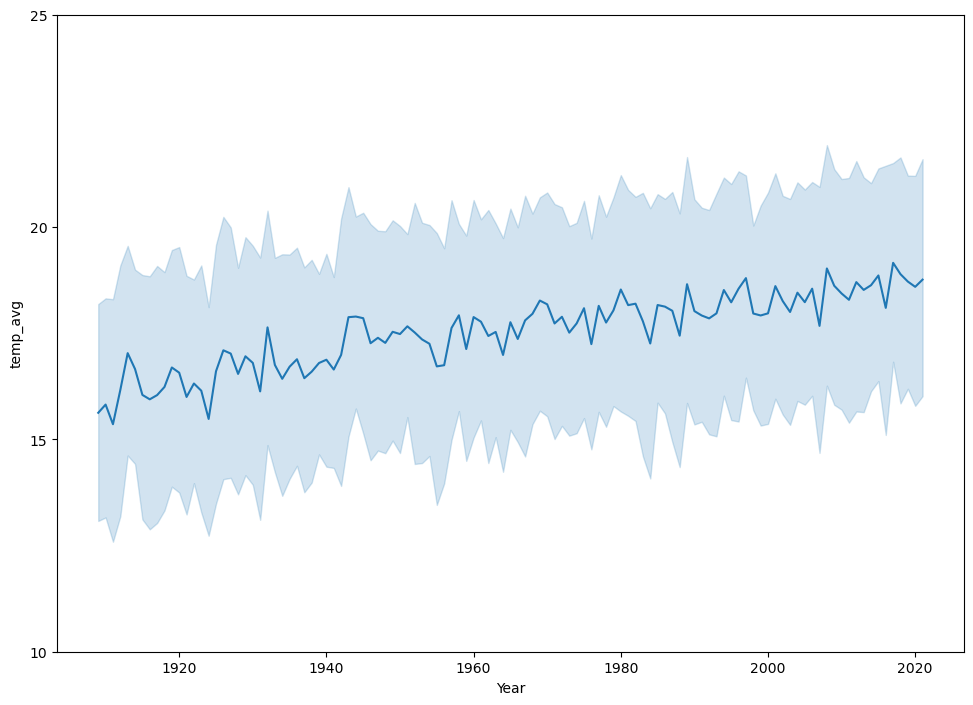

In [729]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(x='Year' ,y='temp_avg', data=df, markers=True, dashes=False)


plt.yticks([10, 15, 20, 25])

In [730]:
df_wide = df.pivot("Year", "Month", "temp_avg")
df_wide.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
1909,23.175806,21.280357,19.170968,17.501667,11.179032,8.413333,9.593548,12.490323,13.583333,14.629032,16.561667,19.958065
1910,23.275806,20.978571,18.188710,15.695000,11.938710,10.771667,8.554839,10.877419,12.420000,15.351613,19.150000,22.658065
1911,23.574194,21.825000,19.398387,15.866667,12.933871,7.946667,9.295161,9.483871,10.446667,14.248387,18.508333,20.783871
1912,23.516129,22.798276,21.127419,15.918333,12.483871,10.231667,8.756452,9.362903,12.755000,16.498387,17.790000,22.753226
1913,22.883871,25.601786,19.230645,18.436667,14.887097,10.116667,12.606452,11.633871,13.195000,15.585484,19.205000,21.014516


In [731]:
# VEMOS LA TENDENCIA DE CADA MES A LO LARGO DE LOS AÑOS--------------
#for i in df_wide.columns:
#    plt.figure()
#    plt.tight_layout()
#    sns.set(rc={"figure.figsize":(8, 5)})
#    plt.gca().set(xlabel= i,ylabel='Frequency')
#    sns.lineplot(x= 'Year', y= i ,data=df_wide)
#    plt.yticks([15, 20, 25 , 30])

In [732]:
#Se crean las dummies de los meses para estudiar luego estacionalidad

dummies_mes=pd.get_dummies(df.index.month,drop_first=True)
dummies=pd.DataFrame(dummies_mes)

In [733]:
#Se renombran las dummies y se usa el index del dataframe

dummies=dummies.rename(columns={2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})
dummies.index=df.index
dummies.head(3)

,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
Fecha,,,,,,,,,,,
1909-01,0,0,0,0,0,0,0,0,0,0,0
1909-02,1,0,0,0,0,0,0,0,0,0,0
1909-03,0,1,0,0,0,0,0,0,0,0,0


In [734]:
#Se agregan las dummies al df

df=pd.merge(df, dummies, left_index=True, right_index=True)
df.head(3)

,temp_min,temp_max,temp_avg,Year,Month,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
Fecha,,,,,,,,,,,,,,,,
1909-01,17.422581,28.929032,23.175806,1909,1,0,0,0,0,0,0,0,0,0,0,0
1909-02,16.000000,26.560714,21.280357,1909,2,1,0,0,0,0,0,0,0,0,0,0
1909-03,13.012903,25.329032,19.170968,1909,3,0,1,0,0,0,0,0,0,0,0,0


In [735]:
#Se agregan columnas logaritmicas de la temperatura para hacer pruebas
#df['temp_min_log']=np.log(df['temp_min'])
#df['temp_max_log']=np.log(df['temp_max'])
#df['temp_avg_log']=np.log(df['temp_avg'])

In [736]:
#Se agrega el timeindex

df["timeIndex"] = pd.Series(np.arange(len(df['temp_min'])), index=df.index)

In [737]:
df.head(3)

,temp_min,temp_max,temp_avg,Year,Month,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,timeIndex
Fecha,,,,,,,,,,,,,,,,,
1909-01,17.422581,28.929032,23.175806,1909,1,0,0,0,0,0,0,0,0,0,0,0,0
1909-02,16.000000,26.560714,21.280357,1909,2,1,0,0,0,0,0,0,0,0,0,0,1
1909-03,13.012903,25.329032,19.170968,1909,3,0,1,0,0,0,0,0,0,0,0,0,2


In [738]:
#Trabajamos primero con la temperatura minima

In [739]:
# Dividimos en train y test
df_train, df_test = train_test_split(df, test_size=48, random_state=42, shuffle=False)

In [740]:
#Modelamos estacionalidad

model_est = smf.ols('temp_min ~ timeIndex + feb +	mar +	apr +	may +	jun +	jul +	aug + sep +	oct +	nov +	dec', data = df_train,hasconst=True).fit()

In [741]:
df_train['predict_est'] = model_est.predict(df_train[['timeIndex','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']])


df_test['predict_est'] = model_est.predict(df_test[['timeIndex','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']])

In [742]:
#df_train['back_predict_log_est'] = np.exp(df_train['predict_log_est'])
#df_test['back_predict_log_est'] = np.exp(df_test['predict_log_est'])

In [743]:
display(df_train.head(2))
display(df_test.head(2))

,temp_min,temp_max,temp_avg,Year,Month,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,timeIndex,predict_est
Fecha,,,,,,,,,,,,,,,,,,
1909-01,17.422581,28.929032,23.175806,1909,1,0,0,0,0,0,0,0,0,0,0,0,0,17.255880
1909-02,16.000000,26.560714,21.280357,1909,2,1,0,0,0,0,0,0,0,0,0,0,1,16.621379


,temp_min,temp_max,temp_avg,Year,Month,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,timeIndex,predict_est
Fecha,,,,,,,,,,,,,,,,,,
2018-01,20.812903,31.406452,26.109677,2018,1,0,0,0,0,0,0,0,0,0,0,0,1308,20.738187
2018-02,20.264286,30.367857,25.316071,2018,2,1,0,0,0,0,0,0,0,0,0,0,1309,20.103686


<AxesSubplot:xlabel='Fecha'>

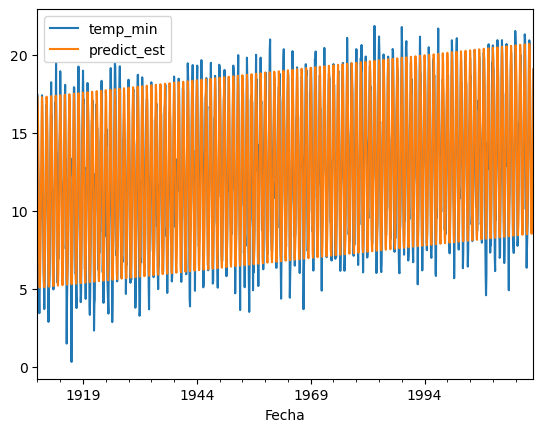

In [744]:
#Ploteamos temp_min contra prediccion de ols
df_train.plot(kind = "line", y = ['temp_min', 'predict_est'])

<AxesSubplot:xlabel='Fecha'>

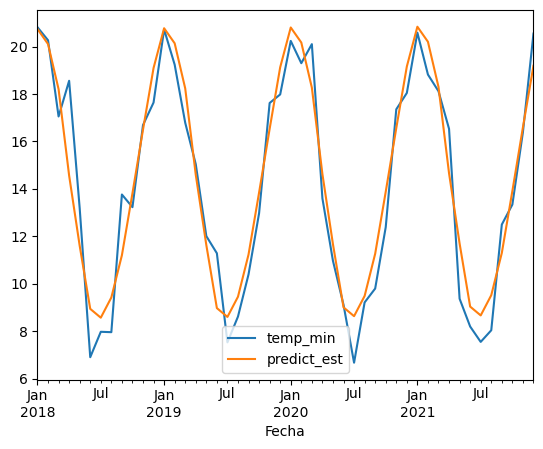

In [745]:
df_test.plot(kind = "line", y = ['temp_min', 'predict_est'])

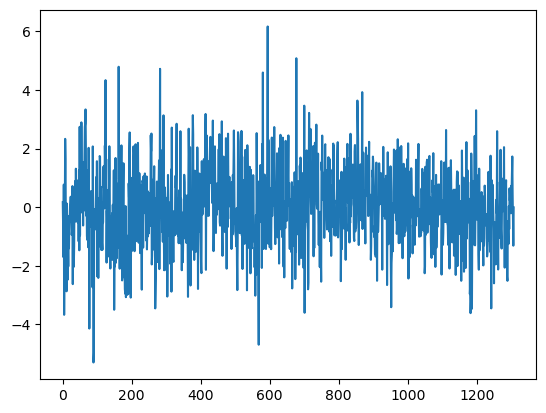

In [746]:
#Calculamos los residuos para hacer Dickey-Fuller y ver si se puede trabajar con los ciclos

res_model = df_train['temp_min'] - df_train['predict_est']

plt.plot(df_train.timeIndex, res_model, '-');

In [747]:
df.iloc[78]

temp_min        4.548387
temp_max       15.132258
temp_avg        9.840323
Year         1915.000000
Month           7.000000
feb             0.000000
mar             0.000000
apr             0.000000
may             0.000000
jun             0.000000
jul             1.000000
aug             0.000000
sep             0.000000
oct             0.000000
nov             0.000000
dec             0.000000
timeIndex      78.000000
Name: 1915-07, dtype: float64

In [748]:
result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -17.862133
p-value: 0.000000
Valor crítico 1%: -3.44
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


In [749]:
#Se puede rechazar la hipotesis nula, y trabajar con los ciclos

In [750]:
#Calculamos AFC para 30 lags

lag_acf = acf(res_model, nlags = 20)
lag_acf


array([ 1.        ,  0.1817886 ,  0.08126227,  0.07037871,  0.01783161,
        0.02060134, -0.01010749,  0.03287855,  0.00227995,  0.05624027,
        0.05864025,  0.02894574,  0.0539158 ,  0.06879158,  0.03405507,
        0.00713931,  0.04102971,  0.01956127,  0.02176209, -0.00148574,
        0.00815299])

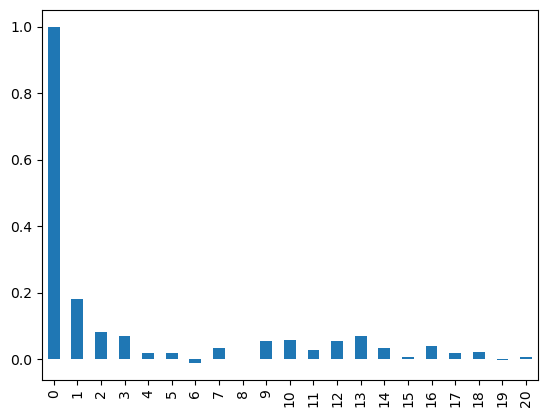

In [751]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

In [752]:
#Calculamos PACF para 30 lags
lag_pacf = pacf(res_model, nlags=20, method='ols')

<AxesSubplot:>

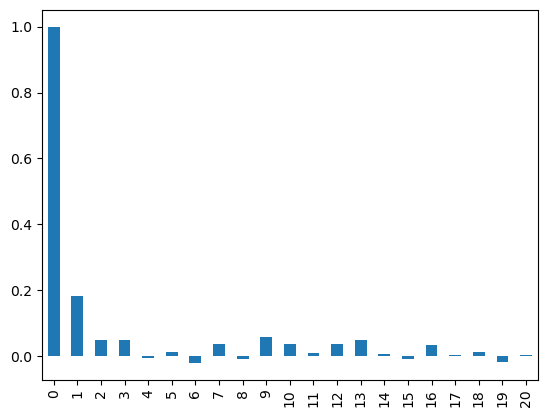

In [753]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar")

In [754]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

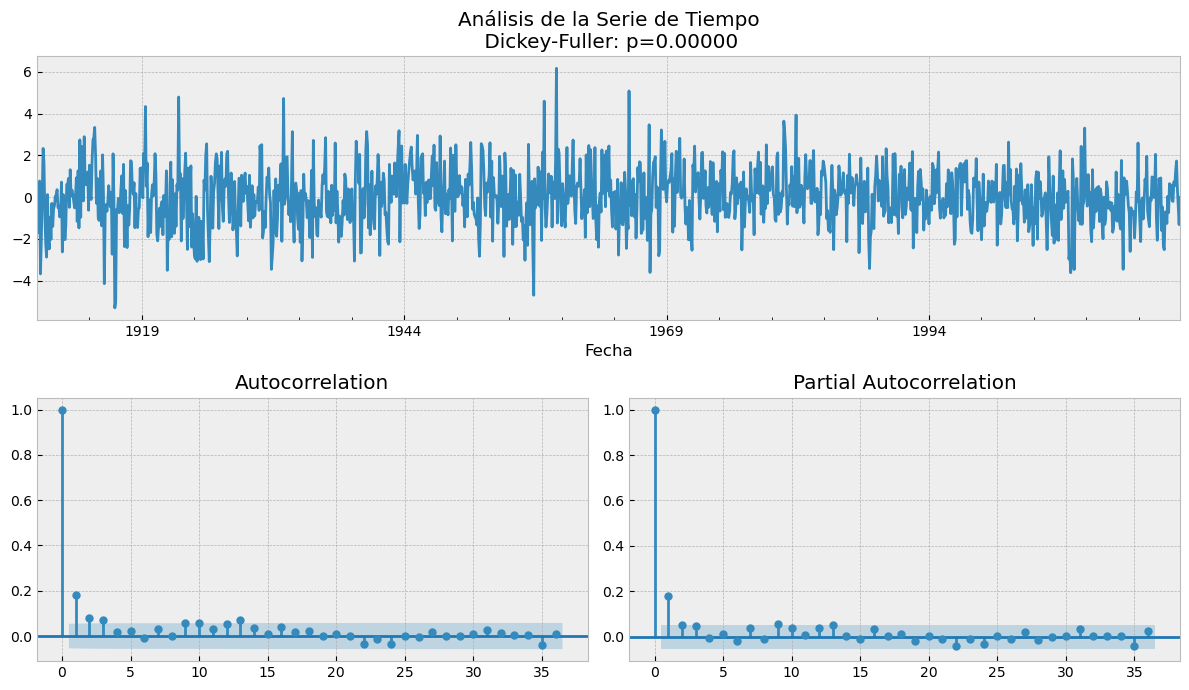

In [755]:
# Corremos la función con nuestra serie res_log:

tsplot(res_model, lags=36)

In [756]:
#Tomamos p=4 y q=2 para Arima

model_ARIMA = sm.tsa.arima.ARIMA(res_model, order=(4,0,2))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

Fecha
1909-01   -0.029886
1909-02    0.005909
1909-03   -0.122284
1909-04   -0.332167
1909-05    0.003891
Freq: M, dtype: float64

In [757]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1308
Model:                 ARIMA(4, 0, 2)   Log Likelihood               -2232.152
Date:                Tue, 07 Mar 2023   AIC                           4480.303
Time:                        14:37:14   BIC                           4521.713
Sample:                    01-31-1909   HQIC                          4495.835
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0299      0.096     -0.310      0.756      -0.219       0.159
ar.L1          0.3552      0.184      1.926      0.054      -0.006       0.717
ar.L2          0.7904      0.210      3.763      0.0

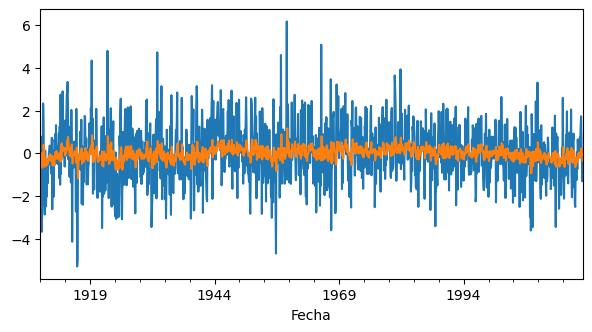

In [758]:
plt.figure(figsize=(7,3.5))
res_model.plot()
results_ARIMA.fittedvalues.plot();

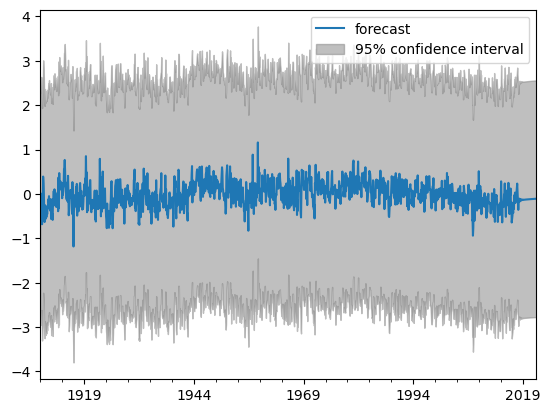

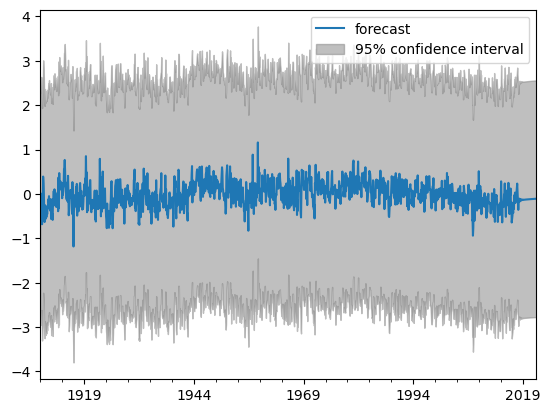

In [759]:
plot_predict(results_ARIMA, end=len(df['temp_min']))

In [760]:
#Analizamos residuos

res_ARIMA =  results_ARIMA.fittedvalues - res_model

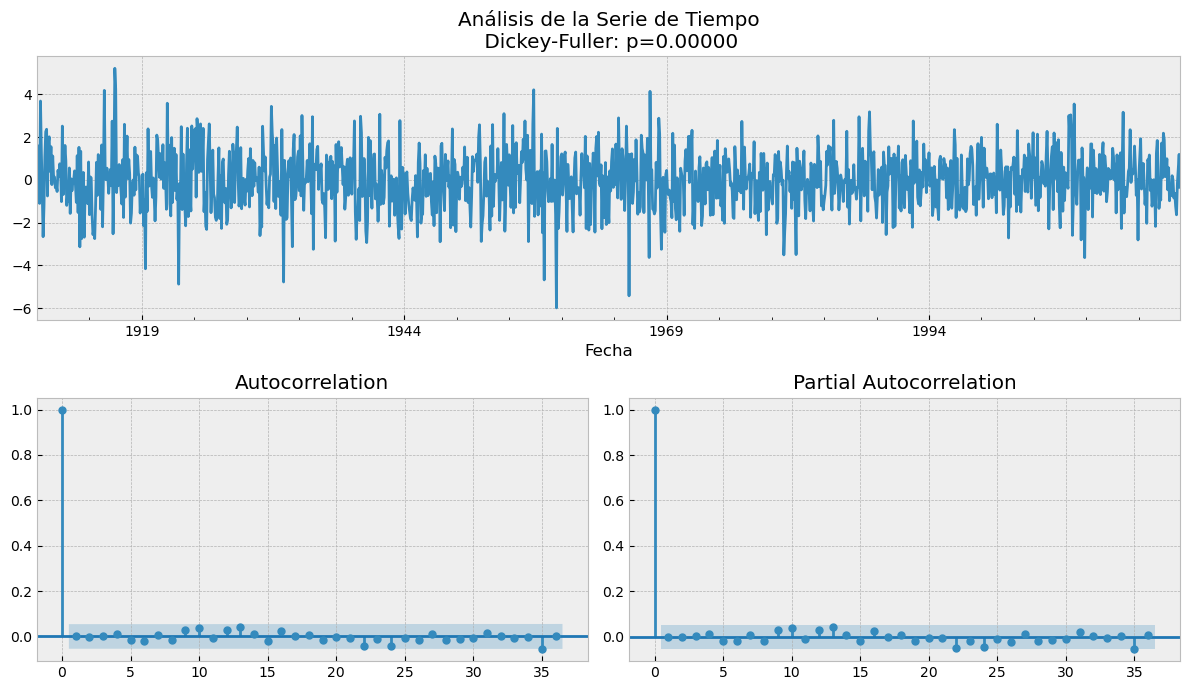

In [761]:
tsplot(res_ARIMA, lags=36)

In [762]:
#Hacemos predicciones out of sample
predictions_ARIMA = results_ARIMA.forecast(len(df_test['temp_min']), alpha=0.05)

In [763]:
#Se incorpora el comportamiento ciclico a nuestro modelo

df_train['model_ARIMA'] = df_train['predict_est'] + results_ARIMA.fittedvalues

df_test['model_ARIMA'] = df_test['predict_est'] + predictions_ARIMA

<AxesSubplot:xlabel='Fecha'>

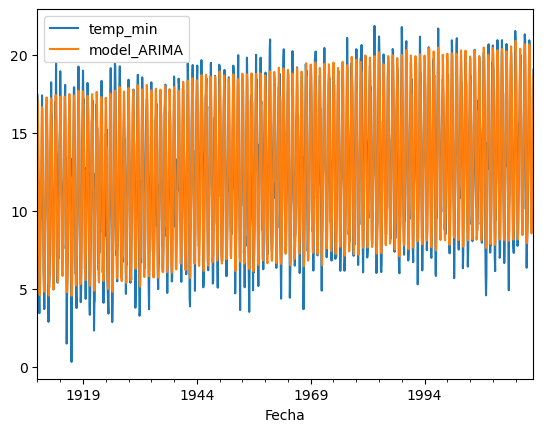

In [764]:
df_train.plot(kind = "line", y = ['temp_min', 'model_ARIMA'])

<AxesSubplot:xlabel='Fecha'>

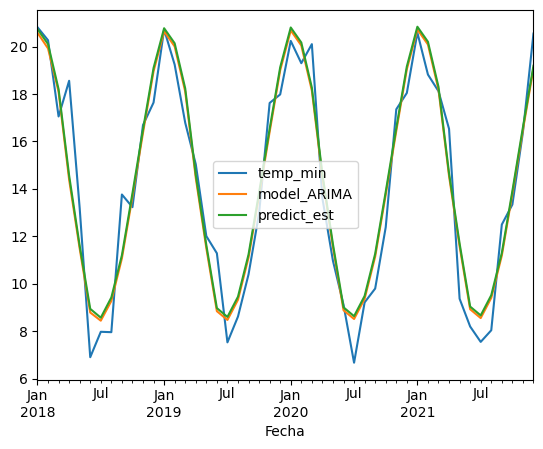

In [765]:
df_test.plot(kind = "line", y = ['temp_min', 'model_ARIMA','predict_est'])

In [766]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [767]:
RMSE(df_test['model_ARIMA'], df_test['temp_min'])

1.313495953402883

In [768]:
RMSE(df_test['predict_est'], df_test['temp_min'])

1.3290672178834564